In [5]:
import numpy as np
from numpy import kron, sqrt, pi, arccos, cos, sin, exp
from numpy.linalg import norm
from numpy.linalg import matrix_power, eig
from scipy.linalg import expm
from copy import deepcopy
import functools as ft

X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1, 0], [0, 1]])

def spectral_norm(U0):
    return np.linalg.norm(U0, ord=2)

def commutator(A, B):
    return A@B - B@A

def local_interaction(n, dict):
    R_list = [I] * n
    for i in dict:
        R_list[i] = dict[i]
    return ft.reduce(kron, R_list)

def neighbor_heisenberg(n_qubit):
    edges = []
    for i in range(n_qubit-1):
        edges.append((i, i+1))    
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    edges.append((0, n_qubit-1))

    for i, j in edges:
        XX += local_interaction(n_qubit, {i:X, j:X})
        YY += local_interaction(n_qubit, {i:Y, j:Y})
        ZZ += local_interaction(n_qubit, {i:Z, j:Z})
        ZZ += local_interaction(n_qubit, {i:Z, j:I}) * 0.2
    return [XX, YY, ZZ]

def sum_second_order_commutator_norm(H_list):
    sum = 0
    n = len(H_list)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_3 in range(gamma_1+1, n):
            for gamma_2 in range(gamma_1+1, n):
                R += commutator(H_list[gamma_3], commutator(H_list[gamma_2], H_list[gamma_1])) / 12
        sum += spectral_norm(R)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_2 in range(gamma_1+1, n):
            R += commutator(H_list[gamma_1], commutator(H_list[gamma_1], H_list[gamma_2])) / 24
        sum += spectral_norm(R)
    return sum

def near_diagonal(R, eigenvalues, eps):
    N = R.shape[0]
    # print(N)
    R_copy = deepcopy(R)
    for i in range(N):
        for j in range(N):
            if abs(eigenvalues[i] - eigenvalues[j]) > eps:
                R_copy[i][j] = 0
    return R_copy

H_tmp = []
def trotter_simulation(H_list, n, T, r):
    U1 = np.eye(2 ** n).astype(np.complex128)
    # print(H_list, T, r)
    for H in H_list:
        H_tmp.append(-1.0j * H * T / r)
        U1 = U1 @ expm(-1.0j * H * T / r)
    return matrix_power(U1, r)

def trotter_error(H_list, n_qubit, T, r):
    U_target = expm(-1.0j* sum(H_list) * T)
    U_impl = trotter_simulation(H_list, n_qubit, T, r)
    return spectral_norm(U_impl - U_target)

def interference_bound_new(R, H, T, eps):
    N = R.shape[0]
    eigenvalues, eigenvectors = eig(H)
    R_norm = spectral_norm(R)
    delta_norm = spectral_norm(near_diagonal(R, eigenvalues, eps)) # eps refers to the spectral gap
    resid_norm = spectral_norm(R-near_diagonal(R, eigenvalues, eps))
    # print(R_norm, delta_norm, resid_norm)
    return (resid_norm *  (1 / (eps * T)) + delta_norm) 

def interference_bound_new2(R, H, T):
    eigenvalues, eigenvectors = eig(H)
    near_norm = {}
    for i in range(-10, 5):        
        if i==-10:
            near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i))
        else:
            near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i)) - spectral_norm(near_diagonal(R, eigenvalues, 2 ** (i-1)))
    interference_R = 0
    for i in range(-10, 5):
        interference_R += near_norm[i] * min(1, 1/(T*(2**i)))
    return interference_R
        

# def interference_bound_new3(R, H, dt):
#     H_mat, R_mat = H, R
#     HR_mat = H_mat + R_mat * dt / (2j) 
#     HR_eigvals, HR_eigvecs = np.linalg.eigh(HR_mat)[0], np.linalg.eigh(HR_mat)[1]
#     H_eigvals, H_eigvecs = np.linalg.eigh(H_mat)[0], np.linalg.eigh(H_mat)[1]

#     eps = 1e-3
#     dim = len(H_eigvals)
#     DR =  np.zeros((dim, dim), dtype=complex)
#     RR =  np.zeros((dim, dim), dtype=complex)

#     B = H_eigvecs.T.conj() @ R_mat @ HR_eigvecs
#     for j in range(dim):
#         for k in range(dim):
#             v, u = H_eigvecs[:, j], HR_eigvecs[:, k]
#             # b_jk = v.T.conj() @ R_mat @ u
#             # print('b_jk: ', b_jk)
#             if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
#                 DR += B[j,k] * np.outer(v, u.conj())
#             else:
#                 RR += 1/(H_eigvals[j] - HR_eigvals[k]) * B[j,k] * np.outer(v, u.conj())

#     print(f'||Delta(R)||={np.linalg.norm(DR, ord=2)}, ||R(R)||={np.linalg.norm(RR, ord=2)}')

#     return np.linalg.norm(DR, ord=2), np.linalg.norm(RR, ord=2)
def interference_bound_new3(R, H, dt, eps = 1e-3, verbose=False):
    H_mat, R_mat = H, R
    HR_mat = H_mat + R_mat * dt / (2j) 
    HR_eigvals, HR_eigvecs = np.linalg.eigh(HR_mat)[0], np.linalg.eigh(HR_mat)[1]
    H_eigvals, H_eigvecs = np.linalg.eigh(H_mat)[0], np.linalg.eigh(H_mat)[1]

    dim = len(H_eigvals)
    DR =  np.zeros((dim, dim), dtype=complex)
    RR =  np.zeros((dim, dim), dtype=complex)

    B = H_eigvecs.T.conj() @ R_mat @ HR_eigvecs
    for j in range(dim):
        for k in range(dim):
            v, u = H_eigvecs[:, j], HR_eigvecs[:, k]
            # b_jk = v.T.conj() @ R_mat @ u
            # print('b_jk: ', b_jk)
            if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
                DR += B[j,k] * np.outer(v, u.conj())
            else:
                RR += 1/(H_eigvals[j] - HR_eigvals[k]) * B[j,k] * np.outer(v, u.conj())

    if verbose: print(f'||Delta(R)||={np.linalg.norm(DR, ord=2)}, ||R(R)||={np.linalg.norm(RR, ord=2)}')

    return np.linalg.norm(DR, ord=2), np.linalg.norm(RR, ord=2)

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt

color_cycle = ["#8491B4FF", "#00A087FF", "#E64B35FF", "#3C5488FF", "#F39B7FFF", "#7E6148FF", "#4DBBD5FF", "#DC0000FF",  "#91D1C2FF", "#B09C85FF", "#923a3a", "#70699e"]
colors = mpl.cycler(color=color_cycle, alpha=[.9] * len(color_cycle)) 
mpl.rc('axes', grid=True, edgecolor='k', prop_cycle=colors)
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.dpi'] = 100

SMALL_SIZE = 12
MEDIUM_SIZE = 14  #default 10
LARGE_SIZE = 16

plt.rcParams['font.family'] = 'sans-serif'
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title


## H=A+B

In [21]:
n = 8
H_list = neighbor_heisenberg(n)
H = H_list[0] + H_list[2]
R = commutator(H_list[0], H_list[2])
R2 = sum_second_order_commutator_norm([H_list[0], H_list[2]])
print(R2)
print(1/24 * np.linalg.norm(commutator(H_list[0], commutator(H_list[0], H_list[2])), ord=2) + 1/12 * np.linalg.norm(commutator(H_list[2], commutator(H_list[0], H_list[2])), ord=2))
print(np.linalg.norm(H_list[0], ord=2), np.linalg.norm(H_list[2], ord=2))

12.560148619736992
12.560148619736989
8.000000000000002 9.6


45.48095564163095
||Delta(R)||=0.0015752850325697581, ||R(R)||=4.790437209611235
r=100, 2, 2
||Delta(R)||=0.00441325526929945, ||R(R)||=7.546185701556454
r=162, 2, 2
||Delta(R)||=0.009017468572219767, ||R(R)||=11.044341559010364
r=264, 2, 2
||Delta(R)||=0.016191705472675542, ||R(R)||=17.755541415778687
r=428, 2, 2
||Delta(R)||=0.027097680781633306, ||R(R)||=28.03612282615125
r=695, 2, 2
||Delta(R)||=0.04278537905814296, ||R(R)||=45.39105296385195
r=1129, 1.5860297742400595, 2
||Delta(R)||=0.0732339456283223, ||R(R)||=75.59938612383351
r=1833, 0.685504365610627, 2
||Delta(R)||=0.11898416012717578, ||R(R)||=119.11002460464154
r=2976, 0.3116801094991026, 2
||Delta(R)||=0.17491238399946832, ||R(R)||=5.472993250446908
r=4833, 0.14998010211740986, 0.7185466380047941
||Delta(R)||=0.10772811510863775, ||R(R)||=5.404420051872133
r=7848, 0.07645939545858968, 0.29843613106267763
||Delta(R)||=0.06634918642773618, ||R(R)||=5.382706694341912
r=12743, 0.041058334353192075, 0.12931799367984836
||Delta

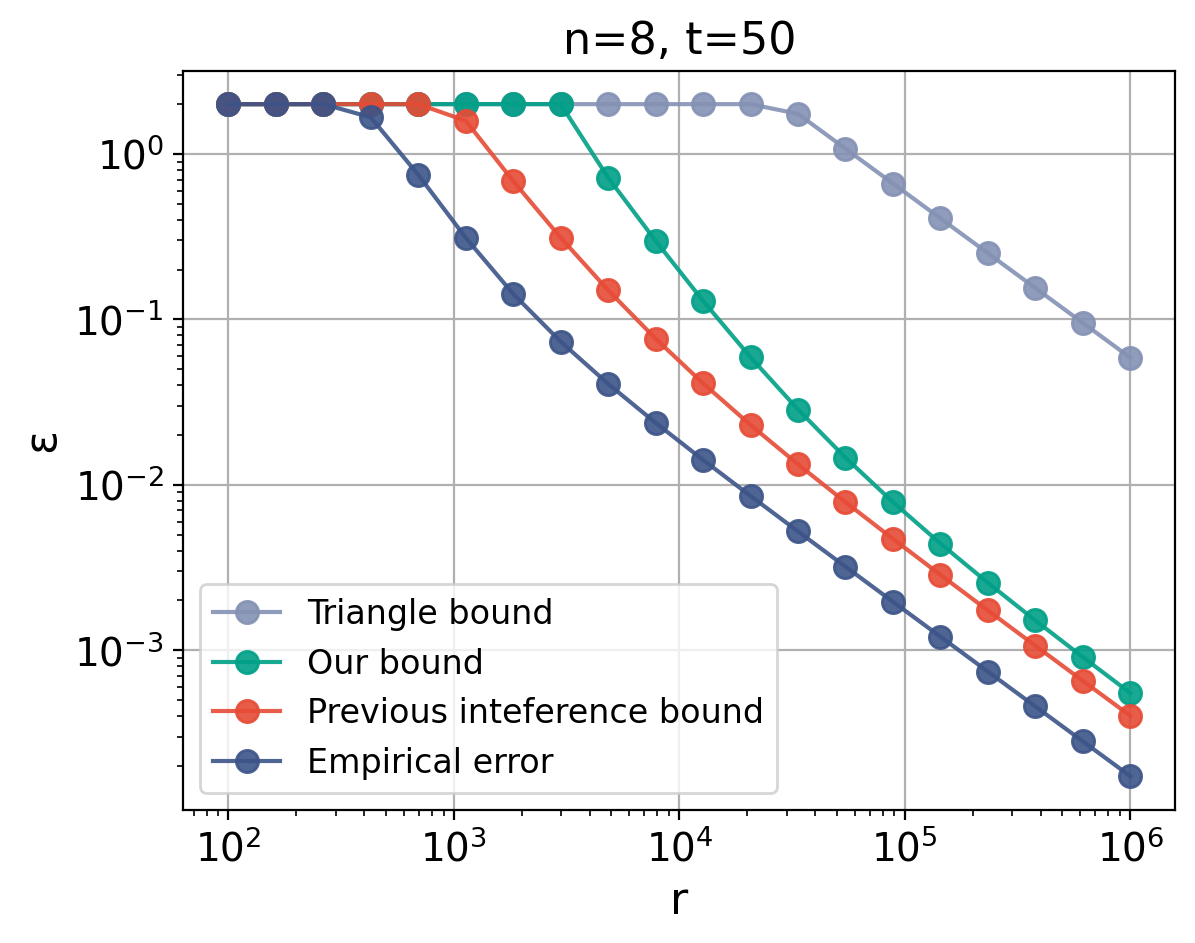

In [27]:
fig, ax = plt.subplots()
n = 8
H_list = neighbor_heisenberg(n)
H = H_list[0] + H_list[2]
R = commutator(H_list[0], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)
print(R2)
A2 = 1/24 * np.linalg.norm(commutator(H_list[0], commutator(H_list[0], H_list[2])), ord=2) + 1/12 * np.linalg.norm(commutator(H_list[2], commutator(H_list[0], H_list[2])), ord=2)

T = 50
eps = 0.0001

emepricial_error = {}
interference_bound = {}
our_interference_bound = {}
triangle_bound = {}

r_num = 20
logspace_seq = np.logspace(2, 6, num = r_num)
# logspace_seq = np.logspace(4, 9, num = 10)

for i in range(r_num):
    r = round(logspace_seq[i])
    # emepricial_error[r] = spectral_norm(expm(-1.0j * H* T - T*T/r * 0.5 * R) - expm(-1.0j * H * T))
    emepricial_error[r] = trotter_error([H_list[0], H_list[2]], n, T, r)
    triangle_bound[r] = min(2, spectral_norm(R) * T*T/r)
    DR, RR = interference_bound_new3(R, H, T/r)
    our_interference_bound[r] = min(triangle_bound[r],  4 * DR * T**2/r + 2 * RR * T/r + R2 * T**3/(r*r))
    interference_bound[r] = min(triangle_bound[r], min(spectral_norm(H_list[0]), spectral_norm(H_list[2])) * T/r + A2 * T**3/r**2 )
    print(f'r={r}, {interference_bound[r]}, {our_interference_bound[r]}')
    # interference_bound[r] = min(2, interference_bound_new2(R, H, T) * T*T/r + R2 * T*T*T/(r*r))
# print(interference_bound_new(R, H, t, eps))
print(emepricial_error, triangle_bound)
title = f"n={n}, t={T}"
x_label = "r"
y_label = "ε"
y_title = "Empirical error"
y1_title = f"Interference bound, ε={eps}"
y2_title = "Triangle bound"
x_list = []
y_list = []
y1_list = []
y2_list = []
y3_list = []
for r in emepricial_error:
    y_list.append((emepricial_error[r]))
    x_list.append(r)
    y1_list.append(interference_bound[r])
    y2_list.append(triangle_bound[r])
    y3_list.append(our_interference_bound[r])
ax.plot(x_list, y2_list, marker="o", label = y2_title)
ax.plot(x_list, y3_list, marker="o", label = 'Our bound')
ax.plot(x_list, y1_list, marker="o", label = 'Previous inteference bound')
ax.plot(x_list, y_list, marker="o", label = y_title)
ax.set_title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc = "best")

## H=A+B+C

||Delta(R)||=0.0642780340133744, ||R(R)||=11.999997580056409
||Delta(R)||=0.11309561479732518, ||R(R)||=14.816517598890341
||Delta(R)||=0.14053226415099576, ||R(R)||=19.806094745851023
||Delta(R)||=0.189785346080773, ||R(R)||=23.53219460712168
||Delta(R)||=0.24707702615692673, ||R(R)||=29.923503510209382
||Delta(R)||=0.314458395720456, ||R(R)||=38.17883876945427
||Delta(R)||=0.4019751261891615, ||R(R)||=48.43793037102309
||Delta(R)||=0.524787418853332, ||R(R)||=61.26901071030895
||Delta(R)||=0.6654192833187607, ||R(R)||=67.9235428293923
||Delta(R)||=0.8418333283136852, ||R(R)||=85.8201897164698
||Delta(R)||=0.9352021885841347, ||R(R)||=29.679165792130984
||Delta(R)||=0.7396024135984838, ||R(R)||=22.494151987791675
||Delta(R)||=0.5842431407153339, ||R(R)||=23.681873502147596
||Delta(R)||=0.4609687522860038, ||R(R)||=24.528998428161227
||Delta(R)||=0.36355157605859806, ||R(R)||=25.103987205521626
||Delta(R)||=0.322792603205773, ||R(R)||=25.48223075532878
||Delta(R)||=0.30268171722786663,

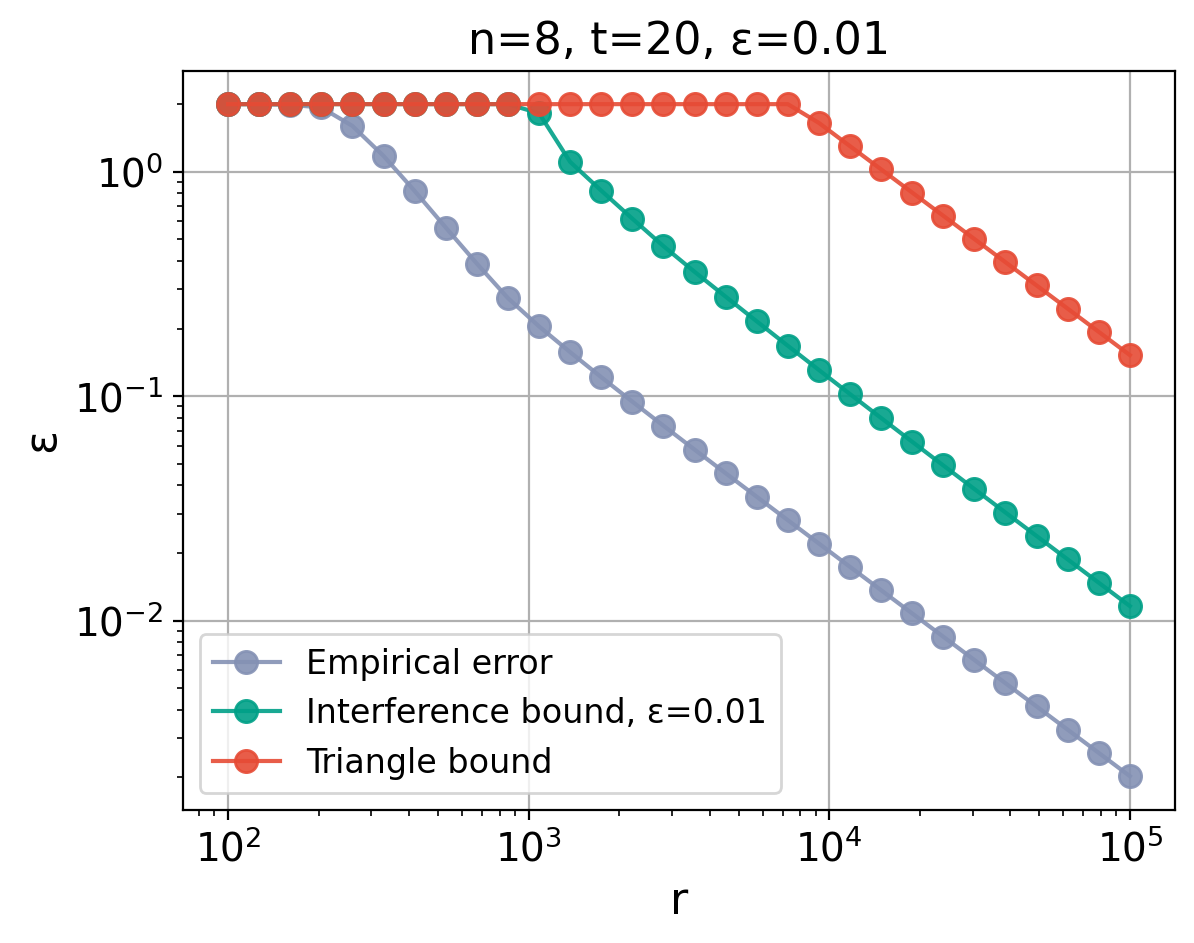

In [10]:
fig, ax = plt.subplots()
n = 8
H_list = neighbor_heisenberg(n)
H = sum(H_list)
R = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)

T = 20
eps = 0.01

emepricial_error = {}
interference_bound = {}
triangle_bound = {}

r_num = 30
logspace_seq = np.logspace(2, 5, num = r_num)
# logspace_seq = np.logspace(4, 9, num = 10)

for i in range(r_num):
    r = round(logspace_seq[i])
    # emepricial_error[r] = spectral_norm(expm(-1.0j * H* T - T*T/r * 0.5 * R) - expm(-1.0j * H * T))
    emepricial_error[r] = trotter_error(H_list, n, T, r)
    DR, RR = interference_bound_new3(R, H, T/r, eps=eps, verbose=True)
    triangle_bound[r] = min(2, spectral_norm(R) * T*T/r)
    # interference_bound[r] = min(triangle_bound[r],  (1+T*eps) * DR * T**2/r + 2 * RR * T/r + R2 * T**3/(r*r))
    interference_bound[r] = min(triangle_bound[r],  4 * DR * T**2/r + 2 * RR * T/r + R2 * T**3/(r*r))
    # interference_bound[r] = min(2, interference_bound_new2(R, H, T) * T*T/r + R2 * T*T*T/(r*r))
# print(interference_bound_new(R, H, t, eps))
print(emepricial_error, triangle_bound)
title = f"n={n}, t={T}, ε={eps}"
x_label = "r"
y_label = "ε"
y_title = "Empirical error"
y1_title = f"Interference bound, ε={eps}"
y2_title = "Triangle bound"
x_list = []
y_list = []
y1_list = []
y2_list = []
for r in emepricial_error:
    y_list.append((emepricial_error[r]))
    x_list.append(r)
    y1_list.append(interference_bound[r])
    y2_list.append(triangle_bound[r])
ax.plot(x_list, y_list, marker="o", label = y_title)
ax.plot(x_list, y1_list, marker="o", label = y1_title)
ax.plot(x_list, y2_list, marker="o", label = y2_title)
ax.set_title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc = "best")

In [170]:
n = 8
H_list = neighbor_heisenberg(n)
H = sum(H_list)
R = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)

T = 20
eps = 1
r = 1000000
h = T*T/r
print(h)
eigenvalues, eigenvectors = eig(H)

near_norm = {}
for i in range(-20, 11):
    near_norm[i] = spectral_norm(near_diagonal(R, eigenvalues, 2 ** i)) - spectral_norm(near_diagonal(R, eigenvalues, 2 ** (i-1)))

interference_R = 0
for i in range(-20, 11):
    interference_R += near_norm[i] * min(1, 1/(2*pi*T*(2**i)))

print(near_norm)
print(interference_R)

print(spectral_norm(expm(-1.0j * H* T - h * R) - expm(-1.0j * H * T))) #emperical error
# print(spectral_norm(near_diagonal(R, eigenvalues, eps)) * h + (spectral_norm(R) - spectral_norm(near_diagonal(R, eigenvalues, eps))) * h / (T * eps)) #interference bound
print(interference_R * h)
print(spectral_norm(R) * h)

0.0004
{-20: 0.0, -19: 0.0, -18: 0.0, -17: 0.0, -16: 0.0, -15: 0.0, -14: 0.0, -13: 0.0, -12: 0.0, -11: 0.0, -10: 0.0, -9: 0.0, -8: 0.0, -7: 8.8, -6: 0.0, -5: 0.0, -4: 0.8664367788756575, -3: 4.419375868779138, -2: 3.1894535369173145, -1: 1.3352687652011639, 0: 2.774002483808644, 1: 2.983441328929718, 2: 4.450334310342825, 3: 5.286452365077555, 4: 3.4405946439588178, 5: 0.5456442739406597, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}
9.3643439230543
0.0004055389354541708
0.00374573756922172
0.015236401742332598


In [1002]:
n = 4
t, r = n, 100
dt = t / r

H_list = neighbor_heisenberg(n)
R = commutator(H_list[0],H_list[1]) + commutator(H_list[1],H_list[2]) + commutator(H_list[2],H_list[0])
# R = commutator(H_list[0],H_list[1]) + commutator(H_list[1],H_list[2]) + commutator(H_list[2],H_list[0])
H = sum(H_list)
HR = H + R * dt / (2j)

HR_eigvals, HR_eigvecs = np.linalg.eigh(HR)[0], np.linalg.eigh(HR)[1]
H_eigvals, H_eigvecs = np.linalg.eigh(H)[0], np.linalg.eigh(H)[1]
print('test correctness of eigen: ', norm(np.dot(H, H_eigvecs[:, 2]) - H_eigvals[2] * H_eigvecs[:, 2], ord=1))
print('HR_eigvals: ', HR_eigvals)
print('H_eigvals: ', H_eigvals)
# print('|HR_eigvals-H_eigvals|: ', norm(HR_eigvals - H_eigvals, ord=1))
# print(norm(HR_eigvals-H_eigvals, ord=2))

eps = 1e-3
dim = 2**n
DR =  np.zeros((dim, dim), dtype=complex)
RR =  np.zeros((dim, dim), dtype=complex)

for j in range(dim):
    for k in range(dim):
        v, u = HR_eigvecs[:, j], HR_eigvecs[:, k]
        b_jk = v.T.conj() @ R @ u
        # print('b_jk: ', b_jk)
        if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
            print(H_eigvals[j], HR_eigvals[k])
            DR += b_jk * v @ u.T.conj()
        else:
            print(H_eigvals[j]-HR_eigvals[k])
            RR += 1/(H_eigvals[j] - HR_eigvals[k]) * b_jk * v @ u.T.conj()

# print(DR, RR)
print(f"||Delta(R)||={norm(DR, ord=2)}, ||R(R)||={norm(RR, ord=2)}")

test correctness of eigen:  2.49479500149234e-15
HR_eigvals:  [-8.03003650e+00 -4.42014790e+00 -3.98028402e+00 -3.60999827e+00
 -5.99262014e-01 -2.87785636e-01 -2.00763647e-01  3.24250366e-16
  2.00763647e-01  2.76789416e-01  5.99262014e-01  3.06544730e+00
  3.60999827e+00  3.94479025e+00  4.42014790e+00  5.01107920e+00]
H_eigvals:  [-8.02981083e+00 -4.41500915e+00 -3.98024805e+00 -3.61500915e+00
 -5.99252348e-01 -2.87318241e-01 -2.00747652e-01 -1.07836911e-16
  2.00747652e-01  2.77394009e-01  5.99252348e-01  3.20000000e+00
  3.61500915e+00  4.01998311e+00  4.41500915e+00  4.80000000e+00]
-8.029810834988577 -8.030036500526638
-3.609662934489827
-4.04952681330796
-4.419812561490382
-7.430548821164219
-7.742025198696156
-7.829047188270079
-8.029810834988577
-8.230574481707077
-8.306600250674283
-8.629072848812935
-11.095258132884618
-11.639809108486777
-11.974601083366316
-12.449958735487327
-13.040890031528763
3.615027347122197
0.005138747094309615
-0.43472513172382365
-0.80501087990624

## Debug

## Eigen decomposition

In [13]:
# test = [[1,0], [0,-1]]
v1, v2 = np.array([1,0]), np.array([0,1j])
print(np.outer(v1, v2))
print(np.outer(v1, v2.T))
print(np.outer(v1, v2.conj()))
print(v1 @ v2.T.conj())
print(v1.T.conj() @ v2)

[[0.+0.j 0.+1.j]
 [0.+0.j 0.+0.j]]
[[0.+0.j 0.+1.j]
 [0.+0.j 0.+0.j]]
[[0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j]]
0j
0j


In [14]:
from qiskit.quantum_info import random_hermitian
import numpy as np
from numpy.linalg import norm

# M = [[1,0], [0,-1]]
n = 2
A = random_hermitian(2**n).to_matrix()
M = A + A.conj().T
M_eigvals, M_eigvecs = np.linalg.eigh(M)[0], np.linalg.eigh(M)[1]
print(M_eigvals)
print(M_eigvecs)
# print('test correctness of eigen: ', norm(M @ M_eigvecs[:, 0] - M_eigvals[0] * M_eigvecs[:, 0], ord=1))
# print('test correctness of eigen: ', norm(np.dot(M, M_eigvecs[:, 1]) - M_eigvals[1] * M_eigvecs[:, 1], ord=1))

dim = 2**n
M_ = np.zeros((dim, dim), dtype=complex)
M_d = M_eigvecs.T.conj() @ M @ M_eigvecs
# print(M_d)
for j in range(dim):
    for k in range(dim):
        v, u = M_eigvecs[:, j], M_eigvecs[:, k]
        # print(f'{j},{k}: {u.T.conj() @ v}')
        # M_ += M_d[j,k] * u @ v.T.conj()
        # M_ += M_d[j,k] * v @ u.T.conj()
        print(f'({j},{k}): {M_d[j,k]}')
        print(np.outer(v, u.conj()))
        M_ += M_d[j,k] * np.outer(v, u.conj())
        # print(v.conj() @ np.outer(v, u.conj()) @ u)
        # print(v @ u.T.conj())
        # print(M_d[j,k])
        # print(M_d[j,k] * v @ u.T.conj())

# for j in range(dim):
#     for k in range(dim):
#         v, u = M_eigvecs[:, j], M_eigvecs[:, k]
#         b_jk = v.T.conj() @ M @ u
#         # print(v.T.conj() @ R_mat @ u * v @ u.T.conj())
#         print('b_jk: ', b_jk)
#         M_ += b_jk * v @ u.T.conj()
# print(M_eigvecs.T.conj() @ M_ @ M_eigvecs)
print('M: \n', M)
print('M_: \n', M_)
print('test correctness of M_: ', norm(M - M_, ord=1))

[-4.63308123 -2.98787971 -1.1997142   2.09844927]
[[-0.87904721+0.j          0.43375788+0.j          0.16891212+0.j
  -0.1029505 +0.j        ]
 [-0.11137666+0.16392401j -0.18969151+0.54415499j  0.06778667-0.6998196j
   0.26299185-0.25520465j]
 [-0.0263503 +0.06332967j -0.31948304-0.00626294j  0.22251162+0.02816896j
  -0.75599651-0.52091337j]
 [ 0.19262136-0.38235088j  0.2953337 -0.53892109j  0.18034486-0.62793073j
  -0.10449213-0.03615247j]]
(0,0): (-4.633081229964122-6.146591422856911e-18j)
[[ 0.77272399+0.00000000e+00j  0.09790534+1.44096947e-01j
   0.02316316+5.56697708e-02j -0.16932327-3.36104470e-01j]
 [ 0.09790534-1.44096947e-01j  0.03927584+5.73992811e-20j
   0.01331606+2.73399936e-03j -0.08413001-1.10096958e-02j]
 [ 0.02316316-5.56697708e-02j  0.01331606-2.73399936e-03j
   0.00470499+9.56324362e-20j -0.02928979+2.12358535e-03j]
 [-0.16932327+3.36104470e-01j -0.08413001+1.10096958e-02j
  -0.02928979-2.12358535e-03j  0.18329518-6.70800192e-18j]]
(0,1): (-8.542041292977245e-16-3.5

In [24]:
n = 6
J, h = 1, 0.2 
# hnn = Nearest_Neighbour_1d(n=n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=True)
# hnn.ham_par
# hnn.ham_xyz
# H_list = hnn.ham_xyz
H_list = neighbor_heisenberg(n)
# tight_bound(hnn.ham_xyz, 2, 2, 10)
# pf(h_list_par, t, r, order=1)
t, r = n, 100
dt = t / r
R = commutator(H_list[0],H_list[1]) + commutator(H_list[1],H_list[2]) + commutator(H_list[2],H_list[0])
# X, Y, Z = H_list[0], H_list[1], H_list[2]
# XY = commutator(X,Y)
# YZ = commutator(Y,Z)
# XZ = commutator(X,Z)
# # XY = commutator(X,Y).simplify()
# # YZ = commutator(Y,Z).simplify()
# # XZ = commutator(X,Z).simplify()
# R = XY + YZ + XZ
# L1 = 1/2 * (norm(commutator(X, YZ).simplify())) + 1/6 * (norm(commutator(X,XY).simplify() + commutator(X,XZ).simplify() + commutator(Y,YZ).simplify()))
# L2 = 1/12 * norm(commutator(X, commutator(X,YZ).simplify()).simplify())

R_mat = R
# init_st = np.linalg.eigh(R_mat)[1][-1]
H_mat = sum(H_list)
# HR_mat = H_mat + R_mat * dt / (2j)
HR_mat = H_mat
HR_eigvals, HR_eigvecs = np.linalg.eigh(HR_mat)[0], np.linalg.eigh(HR_mat)[1]
H_eigvals, H_eigvecs = np.linalg.eigh(H_mat)[0], np.linalg.eigh(H_mat)[1]
print('test correctness of eigen: ', norm(np.dot(H_mat, H_eigvecs[:, 2]) - H_eigvals[2] * H_eigvecs[:, 2], ord=1))
print('HR_eigvals: ', HR_eigvals)
print('H_eigvals: ', H_eigvals)
print('|HR_eigvals-H_eigvals|: ', norm(HR_eigvals - H_eigvals, ord=1))

eps = 1e-3
dim = 2**n
DR =  np.zeros((dim, dim), dtype=complex)
RR =  np.zeros((dim, dim), dtype=complex)

B = H_eigvecs.T.conj() @ R_mat @ HR_eigvecs
for j in range(dim):
    for k in range(dim):
        v, u = H_eigvecs[:, j], HR_eigvecs[:, k]
        # b_jk = v.T.conj() @ R_mat @ u
        # print('b_jk: ', b_jk)
        if abs(H_eigvals[j] - HR_eigvals[k]) < eps:
            DR += B[j,k] * np.outer(v, u.conj())
        else:
            RR += 1/(H_eigvals[j] - HR_eigvals[k]) * B[j,k] * np.outer(v, u.conj())

print(f'||Delta(R)||={norm(DR, ord=2)}, ||R(R)||={norm(RR, ord=2)}')
norm(commutator(RR, H_mat) + R_mat, ord=2)

test correctness of eigen:  3.0885825288108066e-14
HR_eigvals:  [-11.2464645   -8.89433685  -8.45389349  -8.09433685  -6.08032119
  -5.58804218  -5.51633076  -5.13867598  -5.06020855  -4.78804218
  -4.71633076  -4.44231339  -4.32916389  -4.02431237  -4.02040587
  -3.64231339  -3.52916389  -2.81117767  -2.39113583  -2.02002697
  -1.98050224  -1.97586304  -1.59113583  -1.21117767  -0.92055175
  -0.69042693  -0.46763969  -0.35121208  -0.03472728   0.01498992
   0.08863276   0.33236031   0.44878792   0.5004966    0.67944825
   0.88863276   0.90957307   1.57865201   2.00645681   2.37865201
   2.63575756   2.81446858   2.98017323   3.09042693   3.12348713
   3.32055175   3.3335695    3.43575756   3.56300142   3.61446858
   3.68184676   4.00501354   4.05119773   4.36300142   4.48184676
   4.69042693   4.8          4.92055175   5.21117767   5.61781559
   6.02001702   6.41781559   6.81117767   7.2       ]
H_eigvals:  [-11.2464645   -8.89433685  -8.45389349  -8.09433685  -6.08032119
  -5.5880421

3.3134200510461277e-13